# Running DYVIPAC on jupyter notebook 

"---------------------------------------------------------------------------------"
"Dynamics Visualization based on Parallel Coordinates (DYVIPAC)"
"Author: Lan Nguyen, Ph.D., University College Dublin, Ireland"
"Python Implementation: Andrea Degasperi, Ph.D. University College Dublin, Ireland"
"---------------------------------------------------------------------------------"

-- Versions
Python 3.8.10 64 bit
Libroadrunner: 2.2.2
Numpy: 1.23.1
-- If creating models 
Antimony: 2.13.2
Tellurium: 2.2.3
-- If parallel computing 
ipyparallel: 8.4.1

In [ ]:
# model creation 

## Input data 

'''
-i 	a filename specifying the input SBML model file
-p 	a filename specifying the parameter file (see section xx)
-c 	a filename specify the file with the species constraint file (see section xx)
-r 	an integer number specifying a random seed (e.g. 0)
-n 	an integer number specifying how many parameter sets to sample within the ranges included in the parameter file  (see Note 5 for a guide on how to set this number).
-l 	search the natural logarithm of the parameter space. Also notice that the parameter values in the output file will be the natural logarithm of the actual parameters.
-s 	this option is to silence the command line output of the program
-h 	add a header to the output file. The stability result is under the column group, while the other column headers are the names of the parameters explored.
-o 	filename specify the name of the output file of the analysis. The default name is output.txt followed by the random seed number, if specified. This will be a table, delimited by spaces, where the first column is an integer indicating the stability of the parameter set, while the other columns are the values of each parameter explored. See below for an explanation of the stability numbers.
'''

### Example 1 - The negative feedback Goodwin model 

In [22]:
input_model_file = 'models//NFB//NFB.xml'
input_parameter_file = 'models//NFB//NFB_params_2.txt'
input_constraint_file = ''
random_seed = 0
number_of_samples = 1000
log_search = False
silence_program = False 
add_header_to_output = True 
output_file_name = f'output_example1_1_{random_seed}.txt'

Example 1.2 - adding headers to output  

In [ ]:
input_model_file = 'models//NFB//NFB.xml'
input_parameter_file = 'models//NFB//NFB_params_6.txt'
input_constraint_file = ''
random_seed = 0
number_of_samples = 5000
log_search = False
silence_program = False 
add_header_to_output = True 
output_file_name = f'output_example1_2_{random_seed}.txt'

### Example 2 - The negative feedback signalling cascade

In [1]:
# negative feedback signalling cascade 

input_model_file = 'models\MAPK\mapk.xml'
input_parameter_file = 'models\MAPK\mapk_p.txt'
input_constraint_file = 'models\MAPK\mapk_con.txt'
random_seed = 0
number_of_samples = 100
log_search = False
silence_program = False 
add_header_to_output = True 
output_file_name = f'output_example2_{random_seed}.txt'

### Example 3 - The mixed feedback signalling cascade 

In [2]:
# The mixed model 

input_model_file = 'models\Mixed\mixed.xml'
input_parameter_file = 'models\Mixed\mixed_p2.txt'
input_constraint_file = 'models\Mixed\mixed_con.txt'
random_seed = 0
number_of_samples = 20000
log_search = False
silence_program = False 
add_header_to_output = True 
output_file_name = f'output_example3_2_{random_seed}.txt'


## The DYVIPAC program 

Run the block below after running the following input block 

In [23]:
# "---------------------------------------------------------------------------------"
# "Dynamics Visualization based on Parallel Coordinates (DYVIPAC)"
# "Author: Lan Nguyen, Ph.D., University College Dublin, Ireland"
# "Python Implementation: Andrea Degasperi, Ph.D. University College Dublin, Ireland"
# "---------------------------------------------------------------------------------"

import roadrunner
import numpy
import sys, getopt
import warnings

#---- Set up from input
# Global variables
inputfile = input_model_file
outputfile = output_file_name
randomseed = random_seed
numberofsamples = number_of_samples
paramsfile = input_parameter_file
constraintsfile = input_constraint_file
constraintsOn = False if input_constraint_file == '' else True 
silenced = silence_program
withHeadings = add_header_to_output
searchLogarithm = log_search

ssPrecision = 1e-8
ssNegativeTolerance = -1e-10
ssInitialisations = 100

from roadrunner import Config
Config.setValue(Config.ROADRUNNER_DISABLE_WARNINGS,True)

'''
resolved bad variant access and disable roadrunner warnings 
https://github.com/sys-bio/roadrunner/issues/991 
'''


#--------FUNCTION DEFINITIONS-----------------------

#return 0 if a steady state was found with the precision of 1e-8
#return 1 if the steady state was not found because max attemps were exceeded
#return 2 if the steady state was not found because the Jacobian is not singular
#return 3 if the steady state was not found because the Damping factor has became to small to continue
#return 4 if the steady state was not found because the Jacobian is not singular, but it is the algorithm's fault, and not a model's problem
#return -1 if the steady state was not found for unknown reasons
def tryToFindSteadyState(rr,printout=True):
    precision = 10
    maxAttempts = 10
    currentAttempt = 0
    while (precision >= ssPrecision):
        try:
            precision = rr.steadyState()
            if (precision < ssPrecision or maxAttempts <= currentAttempt):
                if (printout): print ("Found Steady State with precision:"), precision 
                return 0
            currentAttempt = currentAttempt + 1 
        except RuntimeError as err:
            if (str(err) == 'Maximum iterations exceeded'):
                if (maxAttempts <= currentAttempt):
                    if (printout): print("Could not find a Steady State within the maximum number of attempts")
                    return 1
                else:
                    currentAttempt = currentAttempt + 1
                    pass
            elif (str(err)  == 'Jacobian matrix singular in NLEQ'):
                #sometimes this error appears when the algorithm reaches negative values for the species by mistake.
                #if this is the case, try to rescue and return 4
                for num in rr.model.getStateVector():
                  if num<0:
                    if (printout): print("Cannot compute steady-state: Jacobian matrix singular in NLEQ, but I can recover, it's probably not a model's problem but the algorithm for steady state search")
                    return 4
                if (printout): print("Cannot compute steady-state: Jacobian matrix singular in NLEQ")
                return 2
            elif (str(err)  == 'Damping factor has became to small to continue'):
                if (printout): print("Cannot compute steady-state: Damping factor has became to small to continue")
                return 3
            else:
                if (printout): print ("Could not find a Steady State because of error:", str(err))
                return -1
    

#check if the new array elem is very close to the arrays present in l
def alreadyInList(elem,l):
    for i in range(len(l)):
        #print numpy.linalg.norm(l[i]-elem)
        if numpy.linalg.norm(l[i]-elem)<1e-1:  #Eucledian distance
        #if numpy.absolute(l[i][0]-elem[0])<1e-2:  #absolute difference of first element
            #print numpy.linalg.norm(l[i]-elem)
            return True
        else:
            pass
    return False

#Function to initialise steady state search when the constraints are specified
def initialiseWithConstr(M,C,speciesIDs,listOfConstraintTypes,rr):
    nSpecies = len(speciesIDs)
    nConstraints = len(matrixOfConstraints)
    #initialise return array S
    S = numpy.zeros(nSpecies)
    for j in range(nSpecies):
        #compute C-M*S
        maxAllowed = C-numpy.array(M.dot(S)).reshape(-1,)
        #find which laws species j is in and consider only those maxAllowed
        filteredMaxAllowed = []
        rowNotZero = 0 #in the last nConstraints columns there will be a unique row != 0
        for i in range(len(maxAllowed)):
            if M[i,j] != 0:
                rowNotZero = i
                #correct the max allowed by corresponding multiplier
                filteredMaxAllowed.append(maxAllowed[i]/M[i,j])
        if len(filteredMaxAllowed) == 0:
            #this species is not part of any constraint, init between 0 and 1000
            S[j] = numpy.random.uniform(0,1000)
            rr.model[speciesIDs[j]] = S[j]
        else:
            #find the upperbound
            upperbound = filteredMaxAllowed[0]
            for w in filteredMaxAllowed:
                if upperbound > w: upperbound = w
            #set the value of the species j to the upperbound if this is 
            #a '=' constraint AND we are at the end
            #otherwise sample in [0,upperbound]
            if listOfConstraintTypes[rowNotZero] == '=' and nSpecies - j <= nConstraints:
                S[j] = upperbound
                rr.model[speciesIDs[j]] = S[j]
            else:
                S[j] = numpy.random.uniform(0,upperbound)
                rr.model[speciesIDs[j]] = S[j]
    return S


#try to find more than one steady state searching the space of initial conditions.
def tryToFindSteadyStatesChangingInit(rr,howMany,M,C,speciesIDs,listOfConstraintTypes):
    howManyInitialConds = howMany
    steadyStates = []
    for i in range(howManyInitialConds):
        #If there are constraints everything is managed by the function below:
        if not len(listOfConstraintTypes)==0:
            S = initialiseWithConstr(M,C,speciesIDs,listOfConstraintTypes,rr)
            #print "[debug] Double check constraints:", numpy.array(M.dot(S))
        else:
            initConcIds = rr.model.getFloatingSpeciesInitConcentrationIds()
            for j in initConcIds:
                rr.model[j] = numpy.random.uniform(0,1000)
        #print rr.model.getFloatingSpeciesInitConcentrationIds()
        #print rr.model.getFloatingSpeciesInitConcentrations()
        res = tryToFindSteadyState(rr,printout=False)
        if res == 0:
            #add new steady state only if not already in the list
            ss = rr.model.getFloatingSpeciesConcentrations()
            #Sometimes we end up in negative concentrations, discard these steady states
            discard = False
            for speciesVal in ss:
                if speciesVal < ssNegativeTolerance:
                    discard = True
            #print "[debug] SS:", ss, "\n[debug] Discard:", discard
            if (not discard) and (not alreadyInList(ss,steadyStates)): steadyStates.append(ss)
        elif res == 1:
            #steady state not found because of max attempts reached. Could be param specific, so keep trying
            pass
        elif res == 2:
            #steady state not found because Jacobian matrix is singular. Stop.
            #---- print("Cannot compute steady-state: Jacobian matrix singular in NLEQ")
            #print rr.model.getStateVector()
            #---- sys.exit(1) #workaround. It is fine when using this library
            #---- with moieties conservation, as the model will be reduce and the Jacobian Matrix
            #---- should not be singular. Which means this error is a numerical error and 
            #---- attempting to find a steady state again with anew random initialisation
            #---- can be succesful. If the system is not minimal, then the Jacobian
            #---- matrix will always be singular!
            pass
        elif res == 3:
            #steady state not found because damping factor has became to small to continue. Could be param specific, so keep trying
            pass
        elif res == 4:
            #steady state not found because sometimes this error appears when the algorithm reaches negative values for the species by mistake. Could be param specific, so keep trying
            pass
        else:
            #steady state not found for unknown reason
            warnings.warn("Cannot compute steady-state. Unknown error.", RuntimeWarning)
            # print("Cannot compute steady-state. Unknown error.")
            # sys.exit(1)
    return steadyStates


#try to find the stability of the steady state computing the eigenvalues of the Jacobian matrix
#return True if stable, False if unstable
def isSteadyStateStable(rr,ss):
    rr.model.setFloatingSpeciesInitConcentrations(ss)
    eigen = rr.getReducedEigenValues()
    #eigen = rr.getReducedEigenValues()[:,0]
    #print "[debug] eigen:",eigen,"eigen[0]",eigen[0]
    positive = eigen[eigen>0]
    return len(positive)==0

#function to print the result of the analysis
def printSampleMatrix(m,listOfParamsAndRanges):
    f = open(outputfile, "w")
    if (withHeadings):
        f.write("group\t")
        for j in range(len(listOfParamsAndRanges)):
            f.write(listOfParamsAndRanges[j][0] + '\t')
        f.write('\n')
    for i in range(len(m[0])):
        for j in range(len(m)):
            f.write("%.8f" % m[j][i] + '\t')
        f.write('\n')
    f.close()

#function to print the log_e of the result of the analysis
def printSampleMatrixLog(m,listOfParamsAndRanges):
    f = open(outputfile, "w")
    if (withHeadings):
        f.write("group\t")
        for j in range(len(listOfParamsAndRanges)):
            f.write(listOfParamsAndRanges[j][0] + '\t')
        f.write('\n')
    for i in range(len(m[0])):
        for j in range(len(m)):
            if j==0:
                f.write("%.8f" % m[j][i] + '\t')
            else:
                f.write("%.8f" % numpy.log(m[j][i]) + '\t')
        f.write('\n')
    f.close()
    
#checks whether in column j exists one and only one row that is not zero
#and if that particular row is not already in the list arleadyOK
#if ok, add the row to alreadyOK and return True
#matrix has the form [row,row,row...], so len(matrix) is the number of rows
def isColumnOK(matrix,col,alreadyOK,listOfConstraintTypes):
    counter = 0
    pos = 0
    for i in range(len(matrix)):
        #print "row",i,"column",col,"value",matrix[i][col]
        if matrix[i][col]!=0:
            counter = counter+1
            pos = i
    #print "counter",counter
    if counter==1 and not pos in alreadyOK and listOfConstraintTypes[pos]=='=':
        alreadyOK.append(pos)
        return True
    return False

def findOKcolumn(matrix,alreadyOK,listOfConstraintTypes):
    for j in range(len(matrix[0])):
        if isColumnOK(matrix,j,alreadyOK,listOfConstraintTypes):
            return j
    print("Cannot find suitable column to swap! Some problem with your constraints file? Quit.")
    sys.exit(1)

def swapColumns(matrix,j1,j2):
    for i in range(len(matrix)):
        tmp = matrix[i][j1]
        matrix[i][j1] = matrix[i][j2]
        matrix[i][j2] = tmp

def swapInList(l,j1,j2):
    tmp = l[j1]
    l[j1] = l[j2]
    l[j2] = tmp
    
def arrangeColumns(speciesIDs,matrix,listOfConstraintTypes,numberOfAssignmentConstraints):
    alreadyOK = []
    #~ for j in range(-len(matrix),0):
    for j in range(-numberOfAssignmentConstraints,0):
        if isColumnOK(matrix,j,alreadyOK,listOfConstraintTypes):
            pass
        else:
            j2 = findOKcolumn(matrix,alreadyOK,listOfConstraintTypes)
            swapColumns(matrix,j,j2)
            swapInList(speciesIDs,j,j2)
            
#--------END OF FUNCTION DEFINITIONS-----------------------     
            
#--------BEGIN READING FILES-------------------------------
# 
numpy.random.seed(randomseed)

try:
  rr = roadrunner.RoadRunner(inputfile)
except RuntimeError as err:
  print("Failed to load SBML file:", str(err))
  sys.exit(1)

#Activate and perform Moiety conservation: Model is reduced if necessary
rr.conservedMoietyAnalysis=True
    
#print rr.model.keys()
#load matrix of parameter search ranges
listOfParamsAndRanges = []
try:             
  f = open(paramsfile)
  for l in f:
    s = l.split()
    s[1] = float(s[1])
    if (searchLogarithm and s[1] <= 0):
        print("Search of logarithm space is enabled but one of the parameters has lower bound lower than or equal zero. Quit.")
        sys.exit(1)
    s[2] = float(s[2])
    #print s
    listOfParamsAndRanges.append(s)
  f.close()
except IOError as err:
  print("Failed to load file with parameter ranges:", paramsfile, str(err))
  if paramsfile=='':
    print("file not specified, use option -p")
  else:
    print('') 
  sys.exit(1)

#Need two types of constraints, the = and <
matrixOfConstraints = []
listOfConstraintValues = []
listOfConstraintTypes = []
numberOfAssignmentConstraints = 0
speciesIDs = rr.model.getFloatingSpeciesInitConcentrationIds()
#print speciesIDs
if (constraintsOn):
    #file with conservation constraints provided.
    #load matrix of conservation constraints
    try:             
      f = open(constraintsfile)
      for l in f:
        s = []
        if '<' in l:
            listOfConstraintTypes.append('<')
            s = [x.strip() for x in l.split('<')]
        elif '=' in l:
            listOfConstraintTypes.append('=')
            numberOfAssignmentConstraints += 1
            s = [x.strip() for x in l.split('=')]
        #add symbol of total
        listOfConstraintValues.append(s[1])
        #some checks
        if len(s)==2:
            p = [x.strip() for x in s[0].split('+')]
        else:
            print("Encountered a problem with the constraints file. There should be one and only one < or = delimiter per row. Quit.")
            sys.exit(1)
        #now populate the matrix
        constraintRow = [0]*len(speciesIDs)
        for species in p:
            if '*' in species:
                multiplierAndSpeciesList = species.split('*')
                pos = speciesIDs.index("init(["+multiplierAndSpeciesList[1].strip()+"])")
                constraintRow[pos] = float(multiplierAndSpeciesList[0].strip())
            else:
                pos = speciesIDs.index("init(["+species+"])")
                constraintRow[pos] = 1
        matrixOfConstraints.append(constraintRow)
      f.close()
    except IOError as err:
      print("Failed to load file with constraints:", constraintsfile, str(err))
      if constraintsfile=='':
        print("file not specified, use option -c")
      else:
        print('') 
      sys.exit(1)




## Single-core processing of DYVIPAC 

Following running the block above, run either this block or the block below

In [24]:
#--------DONE READING FILES-------------------------------
        
#generate the parameter sets and then test them
nOfSamples = numberofsamples

if (searchLogarithm):
    paramSets = [numpy.exp(numpy.random.uniform(numpy.log(listOfParamsAndRanges[i][1]),
                                      numpy.log(listOfParamsAndRanges[i][2]),
                                      nOfSamples)) for i in range(len(listOfParamsAndRanges))]
else:
    paramSets = [numpy.random.uniform(listOfParamsAndRanges[i][1],
                                      listOfParamsAndRanges[i][2],
                                      nOfSamples) for i in range(len(listOfParamsAndRanges))]

#print listOfParamsAndRanges

#--------------------- Some info output
if not silenced:
  print("---------------------------------------------------------------------------------")
  print("Dynamics Visualization based on Parallel Coordinates (DYVIPAC)")
  print("Author: Lan Nguyen, Ph.D., University College Dublin, Ireland")
  print("Python Implementation: Andrea Degasperi, Ph.D. University College Dublin, Ireland")
  print("---------------------------------------------------------------------------------")
  print("Model", inputfile, "loaded correctly")
  print("Output file: ", outputfile)
  print("Parameter search ranges file: ", paramsfile)
  print("Number of parameters to search: ", len(listOfParamsAndRanges))
  print("Random seed used: ", randomseed)
  print("Number of samples to test: ", numberofsamples)
  if (constraintsOn): 
      print("Constraints file: ", constraintsfile)
      print("Number of constraints found in constraint file:", len(matrixOfConstraints))
      print("Moiety conservation laws found (should be equal as line above):", rr.model.getNumConservedMoieties())
#---------------------

#---------------------
if constraintsOn:
  #print speciesIDs
  #print "Matrix of constraints:", matrixOfConstraints
  #print "List of constraint Values:", listOfConstraintValues
  #print "List of constraint Types:", listOfConstraintTypes
  arrangeColumns(speciesIDs,matrixOfConstraints,listOfConstraintTypes,numberOfAssignmentConstraints)
  #print speciesIDs
  #print "Matrix of constraints:", matrixOfConstraints
  #print "List of constraint Values:", listOfConstraintValues
  #print "List of constraint Types:", listOfConstraintTypes
M = numpy.matrix(matrixOfConstraints)
C = numpy.array([rr.model[x] for x in listOfConstraintValues])

#---------------------------------------------------------
presetParamSet = False
if (presetParamSet):
  #optionally, preset the search around a set already found
  parameterSetToTest = 1
  #first load the parameters
  listOfGivenParams = []
  listOfParamSets = []
  fileToOpen = "20150514_combined_bistable.txt"
  try:             
    f = open(fileToOpen)
    currentline = 1
    for l in f:
      if currentline == 1: 
          listOfGivenParams = [x.strip() for x in l.split()]
      else:
          listOfParamSets.append([numpy.exp(float(x.strip())) for x in l.split()])
      currentline = currentline+1
    f.close()
  except IOError as err:
    print("Failed to load file with parameter sets:", fileToOpen, str(err))
    if fileToOpen=='':
      print("parameters file not specified, use option -p")
    else:
      print('') 
    sys.exit(1)
  for p in range(1,len(listOfGivenParams)):
    rr.model[listOfGivenParams[p]]=listOfParamSets[parameterSetToTest][p]  

#---------------------------------------------------------

analysisResults = []
#Main loop
for i in range(nOfSamples):
    oneTenth = nOfSamples/10
    if not silenced: 
        if i in [oneTenth,oneTenth*2,oneTenth*3,oneTenth*4,oneTenth*5,oneTenth*6,oneTenth*7,oneTenth*8,oneTenth*9]:
            print ("Progress on random seed",randomseed,"-",float(i)/nOfSamples*100,"%")
    #set model to desired parameter point
    for j in range(len(listOfParamsAndRanges)):
        rr.model[listOfParamsAndRanges[j][0]]=paramSets[j][i]
    C = numpy.array([rr.model[x] for x in listOfConstraintValues])
    ssList = tryToFindSteadyStatesChangingInit(rr,ssInitialisations,M,C,speciesIDs,listOfConstraintTypes)
    #how many unique steady states where found?
    #print "[debug] number of steady states for current parameter set: ",len(ssList)
    if(len(ssList)==0):
        #Could not find any steady state, return 0
        analysisResults.append(0)
    else: 
        if(len(ssList)==1):
            #Only one steady state found, check stability
            if (isSteadyStateStable(rr,ssList[0])):
                #result: one stable ss, return 1
                analysisResults.append(1)
            else:
                #result: one unstable ss, return 2
                analysisResults.append(2)
                print('Abnormal data found 2', i)
        elif(len(ssList)==2):
            #check stability of the three ss
            print('Abnormal data found 3 or 4 or 5', i)
            nStable=0
            nUnstable=0
            for w in range(2):
                if (isSteadyStateStable(rr,ssList[w])):
                    nStable = nStable + 1
                else:
                    nUnstable = nUnstable + 1
            #check how many stable/unstable
            if nStable==2:
                #if we have 2 stable and 0 unstable ss, then there is bistability, return 3
                analysisResults.append(3)
            elif nStable==1:
                #if we have 1 stable and 1 unstable ss, then there is bistability, return 4
                analysisResults.append(4)
            else:
                #if we have 0 stable and 2 unstable ss, then there is bistability, return 5
                analysisResults.append(5)
        elif(len(ssList)==3):
            print('Abnormal data found 6 or 7 or 8', i)
            #check stability of the three ss
            nStable=0
            nUnstable=0
            for w in range(3):
                if (isSteadyStateStable(rr,ssList[w])):
                    nStable = nStable + 1
                else:
                    nUnstable = nUnstable + 1
            #check how many stable/unstable
            if nStable==2 and nUnstable==1:
                #if we have 2 stable and 1 unstable ss, then there is bistability, return 6
                analysisResults.append(6)
            elif nStable==1 and nUnstable==2:
                #if we have 1 stable and 2 unstable ss, then there is bistability, return 7
                analysisResults.append(7)
            else:
                #in the other cases return -3
                analysisResults.append(8)
        else:
            #analysis not attempted: return 0
            #print ssList
            analysisResults.append(0)

#at the end, add results in first column:
paramSets.insert(0,analysisResults)
if searchLogarithm:
    printSampleMatrixLog(paramSets,listOfParamsAndRanges)
else:
    printSampleMatrix(paramSets,listOfParamsAndRanges)    
#for i in range(len(listOfParamsAndRanges)):
#    rr.model[listOfParamsAndRanges[i][0]]
if not silenced: print("Done. Results printed in the file", outputfile)

---------------------------------------------------------------------------------
Dynamics Visualization based on Parallel Coordinates (DYVIPAC)
Author: Lan Nguyen, Ph.D., University College Dublin, Ireland
Python Implementation: Andrea Degasperi, Ph.D. University College Dublin, Ireland
---------------------------------------------------------------------------------
Model models//NFB//NFB.xml loaded correctly
Output file:  output_example1_1_0.txt
Parameter search ranges file:  models//NFB//NFB_params_2.txt
Number of parameters to search:  2
Random seed used:  0
Number of samples to test:  1000
Abnormal data found 2 55
Abnormal data found 2 69
Abnormal data found 2 76
Abnormal data found 2 80
Abnormal data found 2 90
Progress on random seed 0 - 10.0 %
Abnormal data found 2 113
Abnormal data found 2 115
Abnormal data found 2 133
Abnormal data found 2 141
Abnormal data found 2 152
Abnormal data found 2 176
Abnormal data found 2 192
Abnormal data found 2 197
Progress on random seed 0 - 2

## Multi-core processing of DYVIPAC 

WARNING: DOES NOT WORK YET

In [4]:
from ipyparallel import Client
#--------DONE READING FILES-------------------------------
        
#generate the parameter sets and then test them
nOfSamples = numberofsamples

if (searchLogarithm):
    paramSets = [numpy.exp(numpy.random.uniform(numpy.log(listOfParamsAndRanges[i][1]),
                                      numpy.log(listOfParamsAndRanges[i][2]),
                                      nOfSamples)) for i in range(len(listOfParamsAndRanges))]
else:
    paramSets = [numpy.random.uniform(listOfParamsAndRanges[i][1],
                                      listOfParamsAndRanges[i][2],
                                      nOfSamples) for i in range(len(listOfParamsAndRanges))]

#print listOfParamsAndRanges

#--------------------- Some info output
if not silenced:
  print("---------------------------------------------------------------------------------")
  print("Dynamics Visualization based on Parallel Coordinates (DYVIPAC)")
  print("Author: Lan Nguyen, Ph.D., University College Dublin, Ireland")
  print("Python Implementation: Andrea Degasperi, Ph.D. University College Dublin, Ireland")
  print("---------------------------------------------------------------------------------")
  print("Model", inputfile, "loaded correctly")
  print("Output file: ", outputfile)
  print("Parameter search ranges file: ", paramsfile)
  print("Number of parameters to search: ", len(listOfParamsAndRanges))
  print("Random seed used: ", randomseed)
  print("Number of samples to test: ", numberofsamples)
  if (constraintsOn): 
      print("Constraints file: ", constraintsfile)
      print("Number of constraints found in constraint file:", len(matrixOfConstraints))
      print("Moiety conservation laws found (should be equal as line above):", rr.model.getNumConservedMoieties())
#---------------------

#---------------------
if constraintsOn:
  #print speciesIDs
  #print "Matrix of constraints:", matrixOfConstraints
  #print "List of constraint Values:", listOfConstraintValues
  #print "List of constraint Types:", listOfConstraintTypes
  arrangeColumns(speciesIDs,matrixOfConstraints,listOfConstraintTypes,numberOfAssignmentConstraints)
  #print speciesIDs
  #print "Matrix of constraints:", matrixOfConstraints
  #print "List of constraint Values:", listOfConstraintValues
  #print "List of constraint Types:", listOfConstraintTypes
M = numpy.matrix(matrixOfConstraints)
C = numpy.array([rr.model[x] for x in listOfConstraintValues])

#---------------------------------------------------------
presetParamSet = False
if (presetParamSet):
  #optionally, preset the search around a set already found
  parameterSetToTest = 1
  #first load the parameters
  listOfGivenParams = []
  listOfParamSets = []
  fileToOpen = "20150514_combined_bistable.txt"
  try:             
    f = open(fileToOpen)
    currentline = 1
    for l in f:
      if currentline == 1: 
          listOfGivenParams = [x.strip() for x in l.split()]
      else:
          listOfParamSets.append([numpy.exp(float(x.strip())) for x in l.split()])
      currentline = currentline+1
    f.close()
  except IOError as err:
    print("Failed to load file with parameter sets:", fileToOpen, str(err))
    if fileToOpen=='':
      print("parameters file not specified, use option -p")
    else:
      print('') 
    sys.exit(1)
  for p in range(1,len(listOfGivenParams)):
    rr.model[listOfGivenParams[p]]=listOfParamSets[parameterSetToTest][p]  

#---------------------------------------------------------



analysisResults = []
def append_result(ssList): 

    if(len(ssList)==0):
        #Could not find any steady state, return 0
        return 0
    else: 
        if(len(ssList)==1):
            #Only one steady state found, check stability
            if (isSteadyStateStable(rr,ssList[0])):
                #result: one stable ss, return 1
                return 1
            else:
                #result: one unstable ss, return 2
                print('Abnormal data found 2', i)
                return 2
        elif(len(ssList)==2):
            #check stability of the three ss
            print('Abnormal data found 3 or 4 or 5', i)
            nStable=0
            nUnstable=0
            for w in range(2):
                if (isSteadyStateStable(rr,ssList[w])):
                    nStable = nStable + 1
                else:
                    nUnstable = nUnstable + 1
            #check how many stable/unstable
            if nStable==2:
                #if we have 2 stable and 0 unstable ss, then there is bistability, return 3
                return 3
            elif nStable==1:
                #if we have 1 stable and 1 unstable ss, then there is bistability, return 4
                return 4
            else:
                #if we have 0 stable and 2 unstable ss, then there is bistability, return 5
                return 5
        elif(len(ssList)==3):
            print('Abnormal data found 6 or 7 or 8', i)
            #check stability of the three ss
            nStable=0
            nUnstable=0
            for w in range(3):
                if (isSteadyStateStable(rr,ssList[w])):
                    nStable = nStable + 1
                else:
                    nUnstable = nUnstable + 1
            #check how many stable/unstable
            if nStable==2 and nUnstable==1:
                #if we have 2 stable and 1 unstable ss, then there is bistability, return 6
                return 6
            elif nStable==1 and nUnstable==2:
                #if we have 1 stable and 2 unstable ss, then there is bistability, return 7
                return 7
            else:
                #in the other cases return -3
                return 8
        else:
            #analysis not attempted: return 0
            #print ssList
            return 0 

rc = Client()

for i in range(nOfSamples):
    for j in range(len(listOfParamsAndRanges)):
        rr.model[listOfParamsAndRanges[j][0]]=paramSets[j][i]
    C = numpy.array([rr.model[x] for x in listOfConstraintValues])
    args = (rr,ssInitialisations,M,C,speciesIDs,listOfConstraintTypes)
    with multiprocessing.Pool(os.cpu_count()) as pool: 
        pool.apply_async(ss_parallel, (i,) + args, callback=append_result)


# with multiprocessing.get_context('spawn').Pool(os.cpu_count()) as pool:
#     analysisResults = pool.map(run_dyvipac, range(nOfSamples))
#at the end, add results in first column:
paramSets.insert(0,analysisResults)
if searchLogarithm:
    printSampleMatrixLog(paramSets,listOfParamsAndRanges)
else:
    printSampleMatrix(paramSets,listOfParamsAndRanges)    
#for i in range(len(listOfParamsAndRanges)):
#    rr.model[listOfParamsAndRanges[i][0]]
if not silenced: print("Done. Results printed in the file", outputfile)

---------------------------------------------------------------------------------
Dynamics Visualization based on Parallel Coordinates (DYVIPAC)
Author: Lan Nguyen, Ph.D., University College Dublin, Ireland
Python Implementation: Andrea Degasperi, Ph.D. University College Dublin, Ireland
---------------------------------------------------------------------------------
Model models\MAPK\mapk.xml loaded correctly
Output file:  output_example2_0.txt
Parameter search ranges file:  models\MAPK\mapk_p.txt
Number of parameters to search:  9
Random seed used:  0
Number of samples to test:  100
Constraints file:  models\MAPK\mapk_con.txt
Number of constraints found in constraint file: 3
Moiety conservation laws found (should be equal as line above): 3


In [1]:
from ipyparallel import Client
rc = Client()
print(rc.ids)

Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


OSError: Connection file '~\\.ipython\\profile_default\\security\\ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

## Filter out specific output codes 

### Filter out oscillation 

In [26]:
# filter out specific outputs 

# e.g. we only want code 2 (oscillation)

input_file_name_filter = output_file_name # use the output file name for DYVIPAC   
filter_number = '2'
have_header = True 
output_file_name_filter = f'{input_file_name_filter[:-4]}_filter_{filter_number}.txt' 

read_file = open(input_file_name_filter).readlines()

with open(output_file_name_filter, 'w') as output_file: 
    if have_header:
        output_file.write(read_file[0])
    for line in read_file: 
        if line[0] == filter_number:
            output_file.write(line)



### Filter out bistability 

In [5]:
# filter out specific outputs 

# e.g. we only want code 3 or above 

input_file_name_filter = output_file_name # use the output file name for DYVIPAC   
filter_number = '2'
fn2 = '1'
fn3 = '0'
have_header = True 
output_file_name_filter = f'{input_file_name_filter[:-4]}_filter_bistable.txt' 

read_file = open(input_file_name_filter).readlines()

with open(output_file_name_filter, 'w') as output_file: 
    for line in read_file: 
        if line[0] != filter_number and line[0] != fn2 and line[0] != fn3:
            output_file.write(line)

### Filter both bistability and oscillation 

In [ ]:
# filter out specific outputs 

# e.g. we only want code 2 or above 

input_file_name_filter = output_file_name # use the output file name for DYVIPAC   
fn2 = '1'
fn3 = '0'
have_header = True 
output_file_name_filter = f'{input_file_name_filter[:-4]}_filter_both.txt' 

read_file = open(input_file_name_filter).readlines()

with open(output_file_name_filter, 'w') as output_file: 
    for line in read_file: 
        if line[0] != fn2 and line[0] != fn3:
            output_file.write(line)

## Visualisation? 

In [ ]:
# load in output file and convert it into pandas dataframe format 

### Testing Pandas Parallel Coordinate Plot 

In [30]:
plotting_file_name = 'output_example1_1_0_filter_2.txt'
normalise = False 
figure_size = (12, 6)
image_quality_dpi = 80 

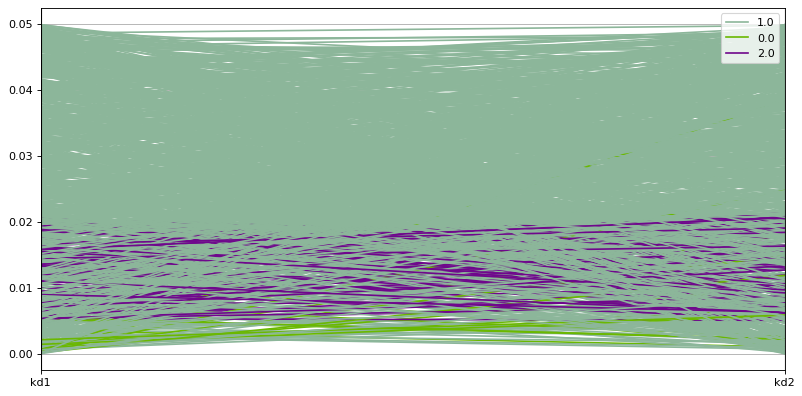

In [31]:
import pandas as pd 
from matplotlib.pyplot import figure

figure(figsize=figure_size, dpi=image_quality_dpi)

df = pd.read_csv(plotting_file_name, delimiter = "\t")
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
if normalise: 
    normalized_df=(df-df.min())/(df.max()-df.min())
    normalized_df['group'] = df['group']

    pd.plotting.parallel_coordinates(
        normalized_df, 'group'
    )
else: 
    pd.plotting.parallel_coordinates(
        df, 'group'
    )

<AxesSubplot:>

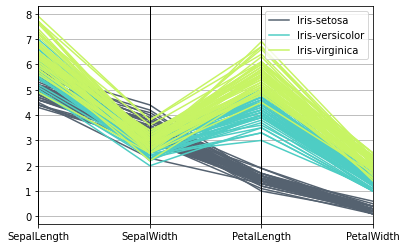

In [1]:
import pandas as pd 

df = pd.read_csv(
    'https://raw.github.com/pandas-dev/'
    'pandas/main/pandas/tests/io/data/csv/iris.csv'
)

pd.plotting.parallel_coordinates(
    df, 'Name', color=('#556270', '#4ECDC4', '#C7F464')
)